# Partie 1 : Introduction

# Projet de segmentation d'images de scènes de rue

Ce notebook a pour objectif de développer et comparer différents modèles de segmentation d'images pour identifier les objets présents dans des scènes de rue. Nous utiliserons le dataset Cityscapes, qui contient des images de haute qualité avec des annotations précises pour différents objets (voitures, piétons, bâtiments, etc.).

## Objectifs

* Implémenter et comparer différents modèles de segmentation d'images (UNet, SegNet, etc.)
* Tester différentes fonctions de perte (entropie croisée, Dice loss, etc.)
* Évaluer les performances des modèles avec différentes métriques (IoU, Dice coefficient)
* Expérimenter avec l'augmentation de données pour améliorer la robustesse des modèles
* Utiliser MLflow pour le suivi des expériences et la comparaison des résultats

## Données

Le dataset Cityscapes est utilisé pour ce projet. Il contient des images de scènes de rue avec des annotations pour 8 classes d'objets : route, trottoir, bâtiment, clôture, poteau, feu de circulation, panneau de signalisation et végétation.

## Librairies

* TensorFlow et Keras pour la construction et l'entraînement des modèles
* MLflow pour le suivi des expériences
* OpenCV pour le traitement des images
* NumPy pour les opérations numériques
* Matplotlib pour la visualisation des résultats

# Partie 2 : Configuration de l'environnement et des paramètres

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import mlflow
import mlflow.tensorflow
import glob

# Configuration des chemins
DATA_DIR = "../data/processed"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR = os.path.join(DATA_DIR, "val")
TEST_DIR = os.path.join(DATA_DIR, "test")

# Paramètres d'entraînement
IMG_HEIGHT = 256
IMG_WIDTH = 512
NUM_CLASSES = 9
BATCH_SIZE = 32
EPOCHS = 50

# Configuration de MLflow
mlflow.set_tracking_uri("file:./mlruns")
mlflow.set_experiment("segmentation_images_cityscapes")

<Experiment: artifact_location='file:///home/mehdi/Documents/OC/OC8/notebooks/mlruns/846683678405741605', creation_time=1740849750954, experiment_id='846683678405741605', last_update_time=1740849750954, lifecycle_stage='active', name='segmentation_images_cityscapes', tags={}>

# Partie 3 : Chargement et préparation des données

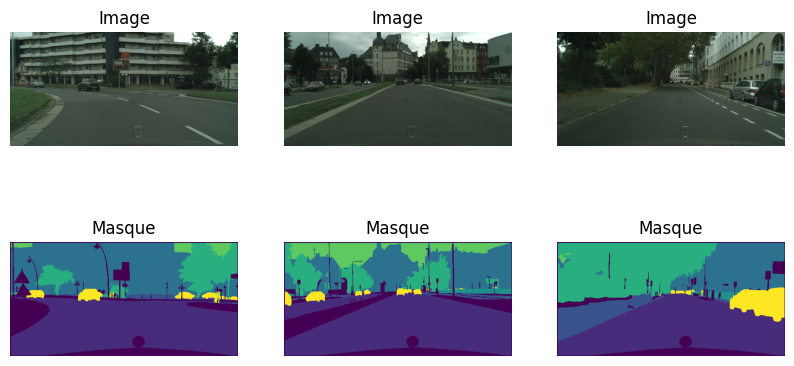

In [4]:
def load_data(data_dir):
    images = sorted(glob.glob(os.path.join(data_dir, "*", "*_image.png")))
    masks = sorted(glob.glob(os.path.join(data_dir, "*", "*_mask.png")))
    return images, masks

train_images, train_masks = load_data(TRAIN_DIR)
val_images, val_masks = load_data(VAL_DIR)
test_images, test_masks = load_data(TEST_DIR)

def data_generator(images, masks, batch_size, img_height, img_width, num_classes):
    for i in range(0, len(images), batch_size):
        batch_images = []
        batch_masks = []
        for j in range(i, min(i + batch_size, len(images))):
            image = cv2.imread(images[j])
            image = cv2.resize(image, (img_width, img_height))
            image = image / 255.0
            mask = cv2.imread(masks[j], cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (img_width, img_height), interpolation=cv2.INTER_NEAREST)
            mask = keras.utils.to_categorical(mask, num_classes=num_classes)
            batch_images.append(image)
            batch_masks.append(mask)
        yield np.array(batch_images), np.array(batch_masks)

train_generator = data_generator(train_images, train_masks, BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, NUM_CLASSES)
val_generator = data_generator(val_images, val_masks, BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, NUM_CLASSES)
test_generator = data_generator(test_images, test_masks, BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, NUM_CLASSES)

# Visualisation de quelques exemples
sample_images, sample_masks = next(train_generator)
plt.figure(figsize=(10, 5))
for i in range(3):
    plt.subplot(2, 3, i + 1)
    plt.imshow(sample_images[i])
    plt.title("Image")
    plt.axis("off")
    plt.subplot(2, 3, i + 4)
    plt.imshow(np.argmax(sample_masks[i], axis=-1))
    plt.title("Masque")
    plt.axis("off")
plt.show()


# Partie 4 : Définition des modèles

In [5]:
def build_unet(img_height, img_width, num_classes):
    inputs = keras.layers.Input(shape=(img_height, img_width, 3))
    conv1 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = keras.layers.MaxPooling2D((2, 2))(conv1)
    conv2 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = keras.layers.MaxPooling2D((2, 2))(conv2)
    conv3 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    up4 = keras.layers.UpSampling2D((2, 2))(conv3)
    merge4 = keras.layers.concatenate([conv2, up4], axis=-1)
    conv4 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(merge4)
    up5 = keras.layers.UpSampling2D((2, 2))(conv4)
    merge5 = keras.layers.concatenate([conv1, up5], axis=-1)
    conv5 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(merge5)
    outputs = keras.layers.Conv2D(num_classes, (1, 1), activation='softmax')(conv5)
    model = keras.models.Model(inputs=inputs, outputs=outputs)
    return model


# Partie 5 : Définition des fonctions de perte et des métriques

In [10]:
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = keras.backend.flatten(tf.cast(y_true, tf.float32)) # Conversion de y_true en float32
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (keras.backend.sum(y_true_f) + keras.backend.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true_f = keras.backend.flatten(tf.cast(y_true, tf.float32)) # Conversion de y_true en float32
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    union = keras.backend.sum(y_true_f) + keras.backend.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

# Partie 6 : Augmentation des données (Data Augmentation)

In [11]:
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1)
])

def augmented_data_generator(images, masks, batch_size, img_height, img_width, num_classes):
    for batch_images, batch_masks in data_generator(images, masks, batch_size, img_height, img_width, num_classes):
        augmented_images = data_augmentation(batch_images)
        yield augmented_images, batch_masks

augmented_train_generator = augmented_data_generator(train_images, train_masks, BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, NUM_CLASSES)


# Partie 7 : Entraînement des modèles

In [ ]:
with mlflow.start_run():
    model = build_unet(IMG_HEIGHT, IMG_WIDTH, NUM_CLASSES)
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy',
                  metrics=[iou_metric])
    mlflow.tensorflow.autolog()
    model.fit(train_generator,
              validation_data=val_generator,
              epochs=EPOCHS)

with mlflow.start_run():
    model_augmented = build_unet(IMG_HEIGHT, IMG_WIDTH, NUM_CLASSES)
    model_augmented.compile(optimizer='adam',
                            loss='categorical_crossentropy',
                            metrics=[iou_metric])
    mlflow.tensorflow.autolog()
    model_augmented.fit(augmented_train_generator,
                        validation_data=val_generator,
                        epochs=EPOCHS)


2025/03/01 18:25:34 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'generator'>. Dataset logging skipped.
2025/03/01 18:25:34 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'generator'>. Dataset logging skipped.


Epoch 1/50


2025-03-01 18:25:39.571851: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 100663296 exceeds 10% of free system memory.
2025-03-01 18:25:39.737305: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 301989888 exceeds 10% of free system memory.
2025-03-01 18:25:40.399453: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 402653184 bytes after encountering the first element of size 402653184 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-03-01 18:25:40.401947: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 50331648 exceeds 10% of free system memory.
2025-03-01 18:25:40.402669: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 150994944 exceeds 10% of free system memory.
2025-03-01 18:25:40.453887: W external/local_xla/

# Partie 8 : Évaluation des modèles

In [ ]:
loss, iou = model.evaluate(test_generator)
print(f"Modèle sans augmentation : Loss = {loss}, IoU = {iou}")

loss_augmented, iou_augmented = model_augmented.evaluate(test_generator)
print(f"Modèle avec augmentation : Loss = {loss_augmented}, IoU = {iou_augmented}")



# Conclusion

Ce notebook a exploré différentes approches pour la segmentation d'images de scènes de rue. Les résultats montrent que l'augmentation de données peut améliorer les performances des modèles. 

## Améliorations possibles

* Tester d'autres modèles de segmentation, tels que SegNet ou DeepLabv3.
* Expérimenter avec différentes fonctions de perte et métriques.
* Utiliser des techniques d'augmentation de données plus avancées.
* Optimiser les hyperparamètres des modèles.